# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import catboost as cb
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
data.index.is_monotonic

True

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
data = data.resample('1H').sum()

In [7]:
data.rolling(3).mean()

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,NaN
2018-03-01 02:00:00,93.333333
2018-03-01 03:00:00,74.000000
2018-03-01 04:00:00,60.000000
...,...
2018-08-31 19:00:00,186.666667
2018-08-31 20:00:00,165.666667
2018-08-31 21:00:00,149.666667


## Analysis

In [8]:
decomposed = seasonal_decompose(data)
decomposed

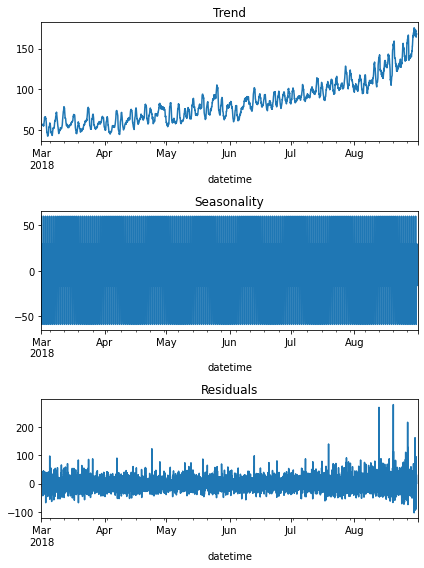

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:title={'center':'Seasonality'}, xlabel='datetime'>

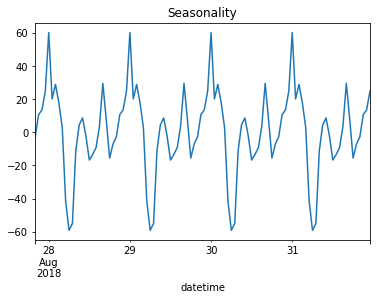

In [10]:
plt.title('Seasonality')
decomposed.seasonal[-100:].plot(ax=plt.gca())

EDA shows that the data begins to skew upwards towards the end of the time period that is given. The seasonal chart also shows that the number of rides seems have 3 peaks throughout the day, with each subsequent peak being busier. The busiest peak maxes out at around midnight and then drastically drops over night.

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Addressed

</div>

## Training

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean())

make_features(data, 4, 4)
data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,86.5


In [12]:
train, mid = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(mid, shuffle=False, test_size=0.5)
train = train.dropna()

In [13]:
len(train)

3528

In [14]:
len(valid)

442

In [15]:
len(test)

442

In [16]:
train = train.dropna()
valid = valid.dropna()
test = test.dropna()

In [17]:
len(train)

3528

In [18]:
len(valid)

442

In [19]:
len(test)

442

In [20]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 04:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


## Testing

The models that will be tested are LinearRegression, DecisionTreeClassifier, RandomForestRegressor, LightGBM, and CatBoost. After the best model is selected based on the validation set, the model will be tested again based on the test set.

In [21]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
print(features_train.index.min(), features_train.index.max())
print(target_train.index.min(), target_train.index.max())
print(features_valid.index.min(), features_valid.index.max())
print(target_valid.index.min(), target_valid.index.max())

2018-03-01 04:00:00 2018-07-26 03:00:00
2018-03-01 04:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00


In [23]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
pred_lr_valid = model_lr.predict(features_valid)

In [24]:
result_lr_valid = mean_squared_error(target_valid, pred_lr_valid)**0.5

In [25]:
print("RMSE for the validation set with LinearRegression: ", result_lr_valid)

RMSE for the validation set with LinearRegression:  40.65791684457176


In [26]:
model_dtr = DecisionTreeRegressor()
model_dtr.fit(features_train, target_train)
pred_dtr_valid = model_dtr.predict(features_valid)
result_dtr_valid = mean_squared_error(target_valid, pred_dtr_valid)**0.5
print("RMSE for the validation set with DecisionTreeRegressor: ", result_dtr_valid)

RMSE for the validation set with DecisionTreeRegressor:  42.119362815478354


In [27]:
model_rfr = RandomForestRegressor()
model_rfr.fit(features_train, target_train)
pred_rfr_valid = model_rfr.predict(features_valid)
result_rfr_valid = mean_squared_error(target_valid, pred_rfr_valid)**0.5
print("RMSE for the validation set with RandomForestRegressor: ", result_rfr_valid)

RMSE for the validation set with RandomForestRegressor:  32.979951238751205


In [28]:
for i in range(10,500,40):
    model = RandomForestRegressor(n_estimators = i)
    model.fit(features_train, target_train)
    pred_rfr_valid = model.predict(features_valid)
    result_rfr_valid = mean_squared_error(target_valid, pred_rfr_valid)**0.5
    print("n_estimators:", i)
    print("RMSE of the linear RandomForestRegressor on the validation set:", result_rfr_valid)

n_estimators: 10
RMSE of the linear RandomForestRegressor on the validation set: 34.12027269893624
n_estimators: 50
RMSE of the linear RandomForestRegressor on the validation set: 33.22350060966154
n_estimators: 90
RMSE of the linear RandomForestRegressor on the validation set: 33.101794054428666
n_estimators: 130
RMSE of the linear RandomForestRegressor on the validation set: 33.16312539181583
n_estimators: 170
RMSE of the linear RandomForestRegressor on the validation set: 32.90802195159078
n_estimators: 210
RMSE of the linear RandomForestRegressor on the validation set: 32.93431477248691
n_estimators: 250
RMSE of the linear RandomForestRegressor on the validation set: 33.184584849565454
n_estimators: 290
RMSE of the linear RandomForestRegressor on the validation set: 33.25005561532908
n_estimators: 330
RMSE of the linear RandomForestRegressor on the validation set: 33.18812781184577
n_estimators: 370
RMSE of the linear RandomForestRegressor on the validation set: 33.176300717889646


In [29]:
for i in range(430,450,2):
    model = RandomForestRegressor(n_estimators = i)
    model.fit(features_train, target_train)
    pred_rfr_valid = model.predict(features_valid)
    result_rfr_valid = mean_squared_error(target_valid, pred_rfr_valid)**0.5
    print("n_estimators:", i)
    print("RMSE of the linear RandomForestRegressor on the validation set:", result_rfr_valid)

n_estimators: 430
RMSE of the linear RandomForestRegressor on the validation set: 33.118746506948945
n_estimators: 432
RMSE of the linear RandomForestRegressor on the validation set: 33.201605437048784
n_estimators: 434
RMSE of the linear RandomForestRegressor on the validation set: 33.18894968884616
n_estimators: 436
RMSE of the linear RandomForestRegressor on the validation set: 33.09744653117066
n_estimators: 438
RMSE of the linear RandomForestRegressor on the validation set: 33.03537327914434
n_estimators: 440
RMSE of the linear RandomForestRegressor on the validation set: 33.05674666031035
n_estimators: 442
RMSE of the linear RandomForestRegressor on the validation set: 33.13520502224916
n_estimators: 444
RMSE of the linear RandomForestRegressor on the validation set: 33.20849320029903
n_estimators: 446
RMSE of the linear RandomForestRegressor on the validation set: 33.11540570921839
n_estimators: 448
RMSE of the linear RandomForestRegressor on the validation set: 33.1539922843232

In [30]:
train_data = lgb.Dataset(features_train, label=target_train)
valid_data = lgb.Dataset(features_valid, label=target_valid)
test_data = lgb.Dataset(features_test, label=target_test)

In [31]:
parameters_1 = {'objective': 'regression',
             'metric': 'rmse',
             'is_unbalance':'true',
             'boosting' : 'gbdt',
             'num_leaves': 5,
             'feature_fraction': 0.5,
             'bagging_fraction': 0.5,
             'bagging_freq': 20,
             'learning_rate': 0.01,
              'verbose': -1
             }

parameters_2 = {'objective': 'regression',
             'metric': 'rmse',
             'is_unbalance':'true',
             'boosting' : 'gbdt',
             'num_leaves': 10,
             'feature_fraction': 0.5,
             'bagging_fraction': 0.5,
             'bagging_freq': 20,
             'learning_rate': 0.01,
              'verbose': -1
             }

parameters_3 = {'objective': 'regression',
             'metric': 'rmse',
             'is_unbalance':'true',
             'boosting' : 'gbdt',
             'num_leaves': 15,
             'feature_fraction': 0.2,
             'bagging_fraction': 0.2,
             'bagging_freq': 20,
             'learning_rate': 0.01,
              'verbose': -1
             }


model_lgbm = lgb.train(parameters_1, train_set = train_data, valid_sets=valid_data, num_boost_round=5000, early_stopping_rounds=50)

In [32]:
train_dataset = cb.Pool(features_train, target_train)
valid_dataset = cb.Pool(features_valid, target_valid)
test_dataset = cb.Pool(features_test, target_test)

In [33]:
model_cb = cb.CatBoostRegressor(loss_function = 'RMSE')

In [34]:
grid = {'iterations': [100, 150, 200],
       'learning_rate': [0.03, 0.1],
       'depth': [2, 4, 6, 8],
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cb.grid_search(grid, train_dataset)

0:	learn: 80.5403586	test: 79.6199059	best: 79.6199059 (0)	total: 46.7ms	remaining: 4.62s
1:	learn: 78.5210952	test: 77.5932927	best: 77.5932927 (1)	total: 47.3ms	remaining: 2.32s
2:	learn: 76.5641769	test: 75.6254538	best: 75.6254538 (2)	total: 47.9ms	remaining: 1.55s
3:	learn: 74.6743176	test: 73.7276790	best: 73.7276790 (3)	total: 48.4ms	remaining: 1.16s
4:	learn: 72.9256003	test: 71.9701989	best: 71.9701989 (4)	total: 49ms	remaining: 931ms
5:	learn: 71.1525037	test: 70.1687246	best: 70.1687246 (5)	total: 49.6ms	remaining: 776ms
6:	learn: 69.4779175	test: 68.4827897	best: 68.4827897 (6)	total: 50.1ms	remaining: 666ms
7:	learn: 67.8763426	test: 66.8690424	best: 66.8690424 (7)	total: 50.6ms	remaining: 582ms
8:	learn: 66.2861876	test: 65.2624566	best: 65.2624566 (8)	total: 51.2ms	remaining: 518ms
9:	learn: 64.8306821	test: 63.7899511	best: 63.7899511 (9)	total: 51.7ms	remaining: 466ms
10:	learn: 63.3690788	test: 62.3092685	best: 62.3092685 (10)	total: 52.4ms	remaining: 424ms
11:	learn:

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [35]:
pred = model_cb.predict(features_valid)
rmse = (np.sqrt(mean_squared_error(target_valid, pred)))
print('testing performance')
print('RMSE:', rmse)

testing performance
RMSE: 32.87682010080971


Out of the 5 models that were tested, all of them had RMSE that were below what the project has requested. However, the DecisionTreeRegressor returned an RMSE value of 0.0. This is suspicious and is most likely an indicator that something is wrong with the code. This value will be disregarded and we will try the next best model (RandomForestRegressor) on the test set. The models have all performed well with the default hyperparameters but n_estimators will be optimized regardless.

In [36]:
print(features_train.index.min(), features_train.index.max())
print(target_train.index.min(), target_train.index.max())
print(features_valid.index.min(), features_valid.index.max())
print(target_valid.index.min(), target_valid.index.max())

2018-03-01 04:00:00 2018-07-26 03:00:00
2018-03-01 04:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00


In [37]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [38]:
print(features_train.index.min(), features_train.index.max())
print(target_train.index.min(), target_train.index.max())

2018-03-01 04:00:00 2018-08-13 13:00:00
2018-03-01 04:00:00 2018-08-13 13:00:00


In [40]:
model_rfr = RandomForestRegressor(n_estimators = 170)
model_rfr.fit(features_train, target_train)
pred_rfr_test = model_rfr.predict(features_test)
result_rfr_test = mean_squared_error(target_test, pred_rfr_test)**0.5
print("RMSE for the test set with RandomForestRegressor: ", result_rfr_test)

RMSE for the test set with RandomForestRegressor:  47.22324122934245


RandomForestRegressor achieved a RMSE of 47.22 with the test dataset. This satisfies the criteria of achieving an RMSE that is below 48.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48